<a href="https://www.kaggle.com/code/samithsachidanandan/pepper-bell-disease-cnn?scriptVersionId=283604757" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

In [1]:
!pip install protobuf==3.20.* --force-reinstall --no-deps

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 162.1/162.1 kB 4.6 MB/s eta 0:00:00
  Attempting uninstall: protobuf
    Found existing installation: protobuf 6.33.0
    Uninstalling protobuf-6.33.0:
      Successfully uninstalled protobuf-6.33.0


In [2]:
import tensorflow as tf 
from tensorflow.keras import models, layers 
import matplotlib.pyplot as plt 
from tensorflow.keras import regularizers
from tensorflow.keras.callbacks import ReduceLROnPlateau,EarlyStopping


import os
import shutil
import warnings

warnings.filterwarnings('ignore')

2025-12-03 11:53:04.425268: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1764762784.630021      20 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1764762784.692257      20 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [3]:
SOURCE_DIR = "/kaggle/input/plant-village/PlantVillage"

DEST_DIR = "/kaggle/working/selected_data"


selected_folders = [
    "Pepper__bell___Bacterial_spot",
    "Pepper__bell___healthy"
]


os.makedirs(DEST_DIR, exist_ok=True)


for folder in selected_folders:
    src_path = os.path.join(SOURCE_DIR, folder)
    dest_path = os.path.join(DEST_DIR, folder)

    if os.path.exists(src_path):
        shutil.copytree(src_path, dest_path, dirs_exist_ok=True)
        print(f"Copied: {folder}")
    else:
        print(f"Folder not found: {folder}")

print("Done!")

Copied: Pepper__bell___Bacterial_spot
Copied: Pepper__bell___healthy
Done!


In [4]:
IMAGE_SIZE = 256
BATCH_SIZE = 32 
CHANNELS = 3
EPOCHS = 100
DATA_DIR = "/kaggle/working/selected_data"


In [5]:
dataset =tf.keras.preprocessing.image_dataset_from_directory(
    DATA_DIR,
    shuffle = True, 
    image_size = (IMAGE_SIZE, IMAGE_SIZE),
    batch_size = BATCH_SIZE
    )

Found 2475 files belonging to 2 classes.


I0000 00:00:1764762816.271352      20 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 13942 MB memory:  -> device: 0, name: Tesla T4, pci bus id: 0000:00:04.0, compute capability: 7.5
I0000 00:00:1764762816.271996      20 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:1 with 13942 MB memory:  -> device: 1, name: Tesla T4, pci bus id: 0000:00:05.0, compute capability: 7.5


In [6]:
class_names = dataset.class_names
class_names

['Pepper__bell___Bacterial_spot', 'Pepper__bell___healthy']

In [7]:
len(dataset)

78

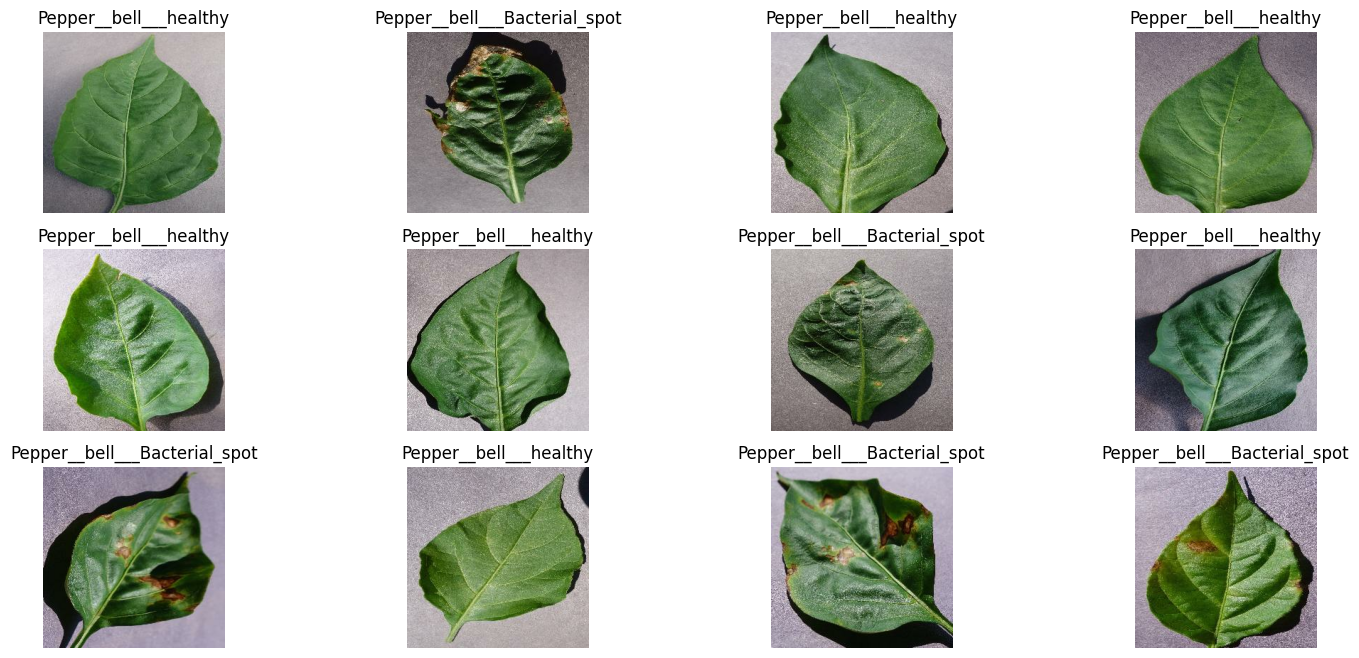

In [8]:
plt.figure(figsize=(18,8))
for image_batch, label_batch in dataset.take(1):

    for i in range(12):
        ax = plt.subplot(3,4, i+1)
        plt.imshow(image_batch[i].numpy().astype('uint8'))
        plt.title(class_names[label_batch[i]])   
        plt.axis('off')

In [9]:
def get_dataset_partitions_tf (ds,train_split=0.8, val_split=0.1, test_split=0.1, shuffle=True,shuffle_size=10000 ):

    ds_size = len(ds)
    if shuffle:
        ds = ds.shuffle(shuffle_size, seed=42)

    train_size = int(train_split * ds_size)
    val_size = int(val_split * ds_size)
    
    train_ds = ds.take(train_size)
    val_ds = ds.skip(train_size).take(val_size)
    test_ds = ds.skip(train_size).skip(val_size)



    return train_ds, val_ds, test_ds 

In [10]:
train_ds, val_ds,test_ds = get_dataset_partitions_tf(dataset)

In [11]:
len(train_ds)

62

In [12]:
len(val_ds)

7

In [13]:
len(test_ds)

9

In [14]:
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=tf.data.AUTOTUNE)  
test_ds = test_ds.cache().prefetch(buffer_size=tf.data.AUTOTUNE)

In [15]:
resize_and_rescale = tf.keras.Sequential([
    layers.Resizing(IMAGE_SIZE, IMAGE_SIZE),
    layers.Rescaling(1.0/255)
])

In [16]:
input_shape = (IMAGE_SIZE, IMAGE_SIZE, CHANNELS)
n_classes = len(class_names)

model = models.Sequential([
    layers.Input(shape=input_shape), 
    resize_and_rescale,

    
    
    layers.Conv2D(32, (3, 3), activation='relu', padding='same'),
    layers.Conv2D(32, (3, 3), activation='relu', padding='same'),
    layers.BatchNormalization(),
    layers.MaxPooling2D((2,2)),
    layers.Dropout(0.2), 
    
   
    layers.Conv2D(64, (3, 3), activation='relu', padding='same'),
    layers.Conv2D(64, (3, 3), activation='relu', padding='same'),
    layers.BatchNormalization(),
    layers.MaxPooling2D((2,2)),
    layers.Dropout(0.2),
    
 
    layers.Conv2D(128, (3, 3), activation='relu', padding='same'),
    layers.Conv2D(128, (3, 3), activation='relu', padding='same'),
    layers.BatchNormalization(),
    layers.MaxPooling2D((2,2)),
    layers.Dropout(0.25), 
    
  
    layers.Conv2D(256, (3, 3), activation='relu', padding='same'),
    layers.Conv2D(256, (3, 3), activation='relu', padding='same'),
    layers.BatchNormalization(),
    layers.MaxPooling2D((2,2)),
    layers.Dropout(0.3), 
    
  
    layers.Flatten(),
    layers.Dense(512, activation='relu'),
    layers.BatchNormalization(),
    layers.Dropout(0.4),  
    layers.Dense(256, activation='relu'),
    layers.Dropout(0.4), 
    layers.Dense(n_classes, activation='softmax'),
])

In [17]:
model.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ sequential (Sequential)         │ (None, 256, 256, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d (Conv2D)                 │ (None, 256, 256, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 256, 256, 32)   │         9,248 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 256, 256, 32)   │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 128, 128, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 128, 128, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 128, 128, 64)   │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 128, 128, 64)   │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 128, 128, 64)   │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 64, 64, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 64, 64, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (None, 64, 64, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_5 (Conv2D)               │ (None, 64, 64, 128)    │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 64, 64, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 32, 32, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 32, 32, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_6 (Conv2D)               │ (None, 32, 32, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_7 (Conv2D)               │ (None, 32, 32, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_3           │ (None, 32, 32, 256)    │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 16, 16, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 16, 16, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 65536)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 512)            │    33,554,94

 Total params: 34,863,010 (132.99 MB)

 Trainable params: 34,861,026 (132.98 MB)

 Non-trainable params: 1,984 (7.75 KB)

In [18]:
optimizer = tf.keras.optimizers.Adam(learning_rate=0.0005)

model.compile(
    optimizer=optimizer,
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

In [19]:
callbacks = [

    ReduceLROnPlateau(
        monitor='val_accuracy',  
        mode='max',              
        factor=0.7,
        patience=2,             
        min_lr=1e-7,
        verbose=1
    ),

    EarlyStopping(
        monitor='val_accuracy',  
        mode='max',             
        patience=5,              
        restore_best_weights=True,
        verbose=1
    )
]

In [20]:
history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs = EPOCHS,
    batch_size = BATCH_SIZE,
     callbacks=callbacks
)

Epoch 1/100


I0000 00:00:1764762830.089692      75 service.cc:148] XLA service 0x78a98802c060 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1764762830.090605      75 service.cc:156]   StreamExecutor device (0): Tesla T4, Compute Capability 7.5
I0000 00:00:1764762830.090625      75 service.cc:156]   StreamExecutor device (1): Tesla T4, Compute Capability 7.5
I0000 00:00:1764762830.913985      75 cuda_dnn.cc:529] Loaded cuDNN version 90300
2025-12-03 11:54:04.178051: E external/local_xla/xla/service/slow_operation_alarm.cc:65] Trying algorithm eng0{} for conv (f32[32,32,3,3]{3,2,1,0}, u8[0]{0}) custom-call(f32[32,32,256,256]{3,2,1,0}, f32[32,32,256,256]{3,2,1,0}), window={size=3x3 pad=1_1x1_1}, dim_labels=bf01_oi01->bf01, custom_call_target="__cudnn$convBackwardFilter", backend_config={"cudnn_conv_backend_config":{"activation_mode":"kNone","conv_result_scale":1,"leakyrelu_alpha":0,"side_input_scale":0},"force_earliest_schedule":false,"operation_qu

62/62 ━━━━━━━━━━━━━━━━━━━━ 69s 566ms/step - accuracy: 0.8240 - loss: 0.4616 - val_accuracy: 0.5670 - val_loss: 2.5011 - learning_rate: 5.0000e-04
Epoch 2/100
62/62 ━━━━━━━━━━━━━━━━━━━━ 12s 189ms/step - accuracy: 0.9366 - loss: 0.1593 - val_accuracy: 0.5670 - val_loss: 1.8362 - learning_rate: 5.0000e-04
Epoch 3/100
62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 187ms/step - accuracy: 0.9631 - loss: 0.0927
Epoch 3: ReduceLROnPlateau reducing learning rate to 0.00035000001662410796.
62/62 ━━━━━━━━━━━━━━━━━━━━ 12s 192ms/step - accuracy: 0.9631 - loss: 0.0927 - val_accuracy: 0.5670 - val_loss: 7.6856 - learning_rate: 5.0000e-04
Epoch 4/100
62/62 ━━━━━━━━━━━━━━━━━━━━ 12s 194ms/step - accuracy: 0.9785 - loss: 0.1230 - val_accuracy: 0.5670 - val_loss: 8.3332 - learning_rate: 3.5000e-04
Epoch 5/100
62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 192ms/step - accuracy: 0.9946 - loss: 0.0406
Epoch 5: ReduceLROnPlateau reducing learning rate to 0.00024500001163687554.
62/62 ━━━━━━━━━━━━━━━━━━━━ 12s 197ms/step - accuracy: 0.9946 - l

In [21]:
model.save('crop_disease_model.keras')

In [22]:
scores = model.evaluate(test_ds)

9/9 ━━━━━━━━━━━━━━━━━━━━ 1s 58ms/step - accuracy: 0.5409 - loss: 2.6512


In [23]:
print(f"Test Accuracy: {scores[1]*100:.2f}%")

Test Accuracy: 56.25%


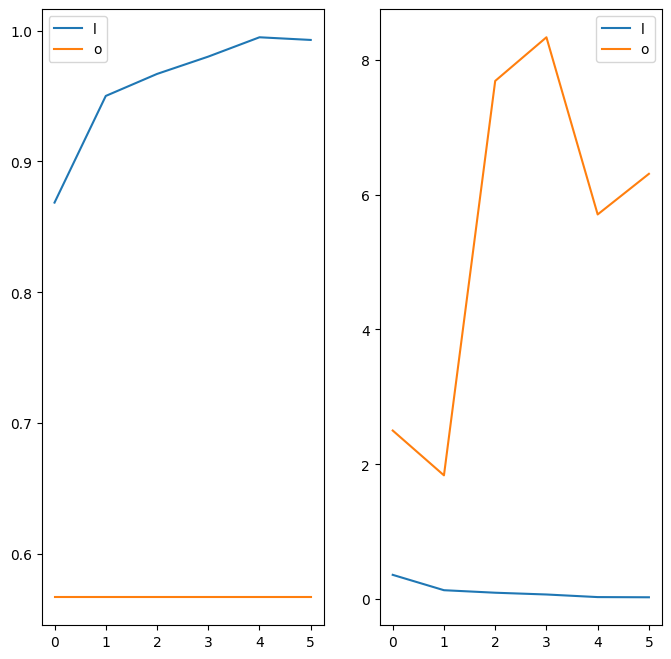

In [24]:
plt.figure(figsize=(8,8))
plt.subplot(1,2,1)
plt.plot(history.history['accuracy'], label='train_accuracy')
plt.plot(history.history['val_accuracy'], label='val_accuracy')
plt.legend('lower right')


plt.subplot(1,2,2)
plt.plot(history.history['loss'], label='train_loss')
plt.plot(history.history['val_loss'], label='val_loss')
plt.legend('lower right')
plt.show()